# <center> Lending Club Default Loan Analysis and Prediction </center>

### Introduction

*With the rise of Machine Learning Technologies, we have seen a considerable increase in Peer to Peer platforms like Lending Club which provides a platform for Lenders and Borrowers*
*All these organizations and any loan giving authority have one thing in common that they use the Credit Score or the parameters used to get a credit score to decide to give out a loan or not,most of these organizations employ their own statistical and classification methods, though build on the same premise every organization have a slightly different way of calculating it. One of the reasons we observe a slight difference when we check our credit score from one of the top 3 organizations that provide credit scores (Equifax, TransUnion, Experian).*

*Lending Club has its entire loan data available on their website, which contains all the connected information about people and the atrributes that are used to calculate the credit score.*

#### Objective:
*In the past 3-4 years Lending Club alone has seen a 30% increase in the loans that get charged off or default,which basically means that the current algorithm being used to put people in one of the buckets(Will Pay, Will not Pay) is failing to work inefficiently, so what I aim here to do is use different classification algorithms and see if I can get a better performance/accuracy than the algorithm in use right now.*
*<a>https://www.pymnts.com/news/alternative-financial-services/2016/lendingclubs-skyrocketing-charge-offs/</a>*

**Step 1: Getting the files-**
*The data can be downloaded in form of csv files from their website*
*<a> https://www.lendingclub.com/info/download-data.action </a>*

In [15]:
import os
import zipfile
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb

**Step 2: Loading the files-**
*The files though csv are downloaded in a zip format. We use the **os** package from python to get the current path and create a folder Lending Club if it does not exist already.*

In [3]:
current_path=os.getcwd()

In [13]:
if not os.path.exists("Lending Club"):
    os.makedirs("Lending Club")
else:
    print("Directory already exists!")

Directory already exists!


In [4]:
os.chdir(current_path+"//Lending Club")

In [8]:
os.getcwd()

'C:\\Users\\Isha\\Lending Club'

*We use the **glob** package to find all the files there which have name starting with LoanStats and save them in a list. Then we use **pandas** to read the file and save them in a pandas dataframe, one thing to notice here is the **compression** parameter- which is important because the csv file is actually in a zip folder so we specify this feature as "zip" to load all the zip files recursively in the dataframe.*

In [37]:
file_list=[]

In [38]:
for name in glob.glob("LoanStats*"):
   file_list.append(name)

In [49]:
df=(pd.read_csv(file,skiprows=1,compression="zip",skipfooter=2,engine='python') for file in file_list)
df1=pd.concat(df,ignore_index=True)

*Once we are done loading the file, we see it has some 145 columns and 443,579 rows. A lot of these columns are either redundant,blank or are derived and if use any derived column are prediction may or may not be accurate*

In [65]:
print("Total number of rows in the dataset:",df1.shape[0],
      "and the total number of columns" ,df1.shape[1])

('Total number of rows in the dataset:', 443579, 'and the total number of columns', 145)


*We create a dataframe called null_values to check the percentage and number of rows it has blank values for*

In [66]:
null_values=pd.DataFrame(df1.isnull().sum()).reset_index()
null_values.rename(columns={'index': 'RowNames', 0: 'Blank RowCount'},inplace=True)

In [68]:
null_values['Percent Blank Values']=(null_values['Blank RowCount']/len(df1))*100

In [70]:
null_values.head()

,RowNames,Blank RowCount,Percent Blank Values
0,id,443579,100.0
1,member_id,443579,100.0
2,loan_amnt,0,0.0
3,funded_amnt,0,0.0
4,funded_amnt_inv,0,0.0


*There are 43 columns with more than 50 percent of blank values and in those case there is no correct way for us to fill the **NULL** values , so we drop those columns and start processing with the rest of them.*

In [75]:
null_values[null_values['Percent Blank Values'] >=50.00].head(10)

,RowNames,Blank RowCount,Percent Blank Values
0,id,443579,100.000000
1,member_id,443579,100.000000
18,url,443579,100.000000
19,desc,443579,100.000000
28,mths_since_last_delinq,222680,50.200753
29,mths_since_last_record,367384,82.822676
50,mths_since_last_major_derog,324968,73.260456
53,annual_inc_joint,401154,90.435751
54,dti_joint,401154,90.435751
55,verification_status_joint,401160,90.437104


In [78]:
null_values[null_values['Percent Blank Values'] >=50.00].count()

RowNames                43
Blank RowCount          43
Percent Blank Values    43
dtype: int64

In [79]:
columns_removed=null_values[null_values['Percent Blank Values']>=50.00]
RemovedData=df1[columns_removed['RowNames']]

*List of all the columns that have less than 50 percent values are saved in a different dataframe "columns_notremoved" and we start working on them.*

In [82]:
columns_notremoved=null_values[null_values['Percent Blank Values']<50.00]

In [84]:
df1=df1[columns_notremoved['RowNames']].reset_index()

*Stripping columns with extra symbols and strings*

In [86]:
df1['int_rate']=(df1['int_rate'].str.replace('%', ''))
df1['revol_util']=(df1['revol_util'].str.replace('%', ''))
df1['term']=(df1['term'].str.replace('months', ''))

### Features we use and how did we find them?

**How is credit score calculated? And how is it calculated. There are 5 categories and each category has certain features and we identify those features.
One of the more important thing to focus here is that no organization calculates the Credit Score rather they classify them based on the same features.**

*Traditionally, this is the most commonly adapted and used method for credit score evaluation. 
Credit Score is divided into 5 categories  and each category has a weight associated with it:*

1.	**Payment History: 35% - **
*This is a log of all the credit you owed for maybe mortgage or student loans and how much have you repaid these loans. It also considers the number of accounts you have and if you have any if you have missed any payments on them.*
2. **Used Credit vs Available Credit: 30% - **
*This is just a measure of the amount you owe on your revolving accounts.If, your credit limit is 5000 and you owe 1000 on it, the revolving utilization will be **(1000/5000) = 0.2** and the revolving utilization will be 20%. The same     approach applies if a user has multiple accounts.*
3. **Type of credit used: 15% - 10% -**
*One of the key factors in determining credit scores is the different type of credits you have (installment, trade, gas station credit, student loans, etc.). This does not have a negative impact on the credit score but someone looking at improving their credit score can do it by having multiple types of credit accounts.
Though opening too many new accounts in a short duration of time can affect the score adversely.*
4. **New credit – 10% - **
*The score is affected by the different types of accounts available. Every time a new account is opened an inquiry is made(hard-pull), which stay in your credit history for the period of 2 years, and they can adversely impact the score if the user has opened multiple accounts very close to each other.*
5. **Length of oldest credit – 5% -**
*The oldest and the latest account opened, the oldest account is important to give creditors an idea that how well the user has handled credit card accounts over a course of time.*


Category | Columns | Description
------------ | -------------
Category 1 | tot_cur_bal | Total Balance owned on the accounts
Category 1 | chargeoff_within_12_mths | Loans that have been charged off
Category 1 | pub_rec_bankruptcies | Public Bankruptcies in the last 7 years
Category 2 | revol_util | Total money owned all accounts/Total credit limit on all accounts
Category 2 | dti | Debt-to-Income Ratio
Category 3 | open_acc |Total number of active accounts
Category 3 | num_bc_tl | Total number of bankcard accounts
Category 3 | num_il_tl | Total number of installment accounts
Category 3 | num_rev_accts | Total number of revolving accounts
Category 4 | inq_last_12m | Inquiries in the last 12 months
Category 5 | mo_sin_old_rev_tl_op | Oldest Account-Months
Category 5 | mths_since_recent_bc | Most recent account opened

### *Checking the distribution of the key variables*

Text(0.5,1,u'Loan Status')

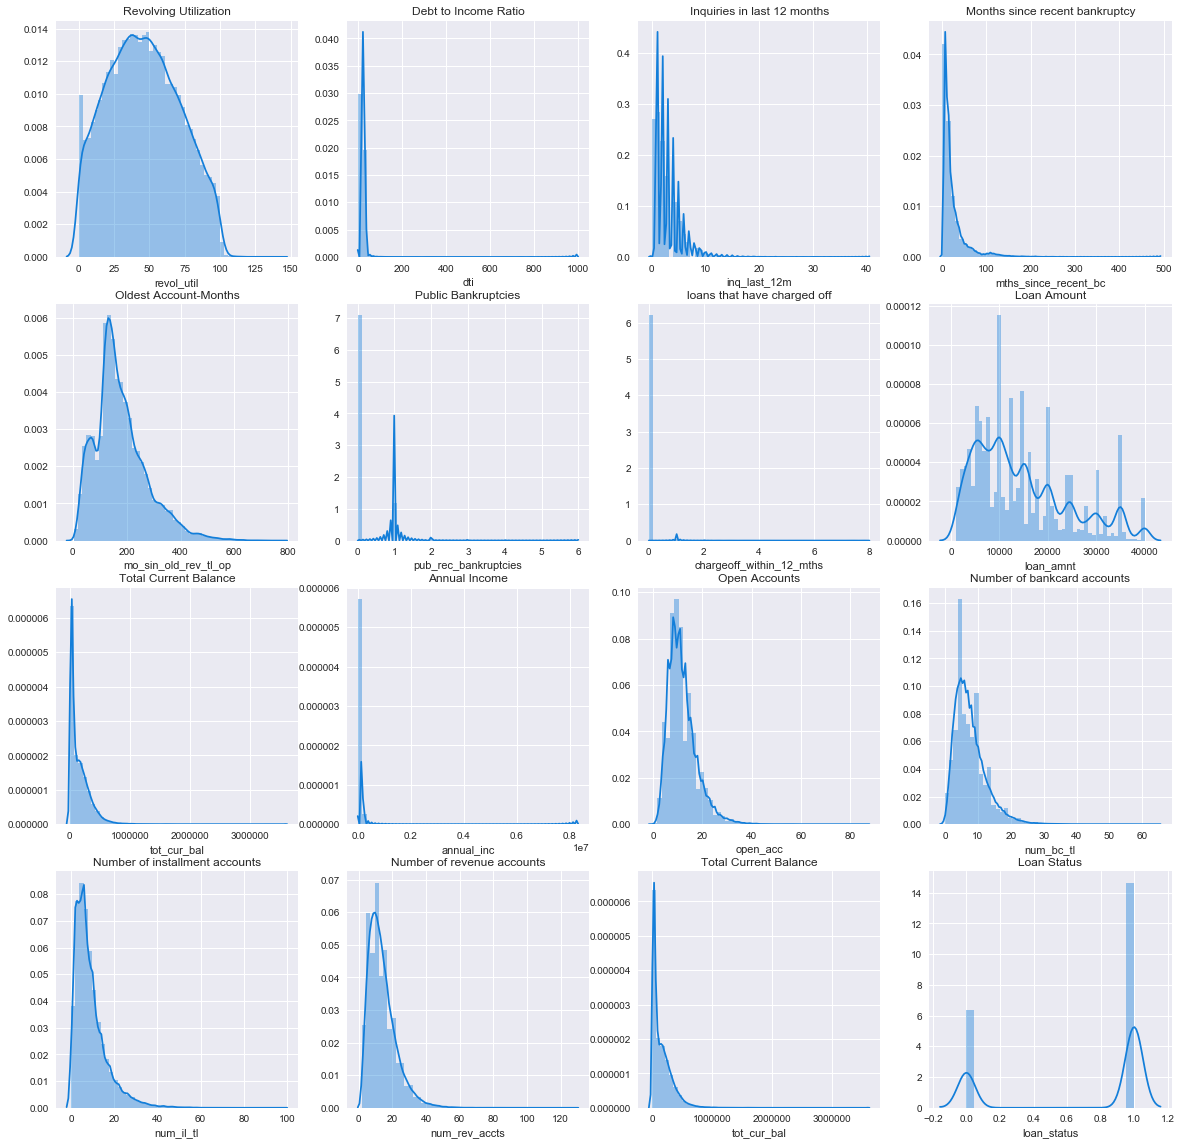

In [334]:
f,axes = plt.subplots(4, 4,figsize=(20, 20))
sb.set_style("darkgrid")
sb.distplot(df4['revol_util'], kde=True, rug=False,color='#137ed9',ax=axes[0][0])
axes[0][0].set_title("Revolving Utilization",fontsize=12)
sb.distplot(df4['dti'], kde=True, rug=False,color='#137ed9',ax=axes[0][1])
axes[0][1].set_title("Debt to Income Ratio",fontsize=12)
sb.distplot(df4['inq_last_12m'], kde=True, rug=False,color='#137ed9',ax=axes[0][2])
axes[0][2].set_title("Inquiries in last 12 months",fontsize=12)
sb.distplot(df4['mths_since_recent_bc'], kde=True, rug=False,color='#137ed9',ax=axes[0][3])
axes[0][3].set_title("Months since recent bankruptcy",fontsize=12)
sb.distplot(df4['mo_sin_old_rev_tl_op'], kde=True, rug=False,color='#137ed9',ax=axes[1][0])
axes[1][0].set_title("Oldest Account-Months",fontsize=12)
sb.distplot(df4['pub_rec_bankruptcies'], kde=True, rug=False,color='#137ed9',ax=axes[1][1])
axes[1][1].set_title("Public Bankruptcies",fontsize=12)
sb.distplot(df4['chargeoff_within_12_mths'], kde=True, rug=False,color='#137ed9',ax=axes[1][2])
axes[1][2].set_title("loans that have charged off",fontsize=12)
sb.distplot(df4['loan_amnt'], kde=True, rug=False,color='#137ed9',ax=axes[1][3])
axes[1][3].set_title("Loan Amount",fontsize=12)
sb.distplot(df4['tot_cur_bal'], kde=True, rug=False,color='#137ed9',ax=axes[2][0])
axes[2][0].set_title("Total Current Balance",fontsize=12)
sb.distplot(df4['annual_inc'], kde=True, rug=False,color='#137ed9',ax=axes[2][1])
axes[2][1].set_title("Annual Income",fontsize=12)
sb.distplot(df4['open_acc'], kde=True, rug=False,color='#137ed9',ax=axes[2][2])
axes[2][2].set_title("Open Accounts",fontsize=12)
sb.distplot(df4['num_bc_tl'], kde=True, rug=False,color='#137ed9',ax=axes[2][3])
axes[2][3].set_title("Number of bankcard accounts",fontsize=12)
sb.distplot(df4['num_il_tl'], kde=True, rug=False,color='#137ed9',ax=axes[3][0])
axes[3][0].set_title("Number of installment accounts",fontsize=12)
sb.distplot(df4['num_rev_accts'], kde=True, rug=False,color='#137ed9',ax=axes[3][1])
axes[3][1].set_title("Number of revenue accounts",fontsize=12)
sb.distplot(df4['tot_cur_bal'], kde=True, rug=False,color='#137ed9',ax=axes[3][2])
axes[3][2].set_title("Total Current Balance",fontsize=12)
sb.distplot(df4['loan_status'], kde=True, rug=False,color='#137ed9',ax=axes[3][3])
axes[3][3].set_title("Loan Status",fontsize=12)

**Debt to Income Ratio** *is one of the key features for our model and it has 7 percent null values and since it does not have gaussian distribution we use Linear Regression to fill the blank values.*

In [1]:
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm

C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**Splitting the dataframe it into 2 dataframes.**
1. *One with null values.*
2. *One which has no null values.*

*We use the **statsmodels** package to create a Linear Regression model for Debt-to-Income Ratio. statsmodels gives a summary of the results with p values and confidence intervals*

In [91]:
blank_dti=df1[df1['dti'].isnull()]
notblank_dti=df1[pd.notnull(df1['dti'])]

In [92]:
x=notblank_dti[['int_rate','revol_bal','annual_inc']]
y=notblank_dti['dti']

In [93]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.80,random_state=1)

### <center> *The Regression Model* </center>

*We get an accuracy of 51.9%, which might not be the best model but it does the job in identifying NA values "dti"*

In [101]:
model=sm.OLS(y_train,x_train.astype(float))
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dti   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 1.275e+05
Date:                Thu, 19 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:44:42   Log-Likelihood:            -1.5296e+06
No. Observations:              354452   AIC:                         3.059e+06
Df Residuals:                  354449   BIC:                         3.059e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
int_rate       1.2054      0.003    416.242      0.000       1.200       1.211
revol_bal      0.0001   1.39e-06     95.799      0.000       0.000       0.000
annual_inc -7.926e-06   3.85e-07    -20.599      0.000   -8.68e-06   -7.17e-06
==============================================================================
Omnibus:                   896101.775   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      27452331810.153
Skew:                          28.013   Prob(JB):                         0.00
Kurtosis:                    1365.227   Cond. No.                     1.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
x_blank=blank_dti[['int_rate','revol_bal','annual_inc']]
y_blank=blank_dti['dti']

*Finding dti values for the dataframe with null values.*

In [107]:
blank_dti['dti']=result.predict((x_blank).astype(float))

C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


*Merging the two dataframes.*

In [108]:
df1=pd.concat([blank_dti,notblank_dti],axis=0)

*Checking if dti has any null values?*

In [109]:
df1[df1['dti'].isnull()]

,index,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag


**revolving_utilization** *has a gaussian distribution and we use median to fill the NA's in revol_util.*

In [182]:
df2['revol_util'][df2['revol_util'].isnull()]=df2['revol_util'].median()

C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [167]:
corr=df2.corr()

*The final columns that we will use for our model*

In [189]:
cols=['tot_cur_bal',
      'loan_amnt',
 'chargeoff_within_12_mths',
 'pub_rec_bankruptcies',
 'revol_util',
 'open_acc',
 'num_bc_tl',
 'num_il_tl',
 'num_rev_accts',
 'inq_last_12m',
 'mo_sin_old_rev_tl_op',
 'mths_since_recent_bc',
 'dti',
"loan_status"]

In [191]:
df3=df2[cols]

In [194]:
df3.dtypes

tot_cur_bal                   int64
annual_inc                  float64
loan_amnt                     int64
chargeoff_within_12_mths      int64
pub_rec_bankruptcies          int64
revol_util                   object
open_acc                      int64
num_bc_tl                     int64
num_il_tl                     int64
num_rev_accts                 int64
inq_last_12m                  int64
mo_sin_old_rev_tl_op          int64
mths_since_recent_bc        float64
dti                         float64
loan_status                  object
dtype: object

**Loan_status** *is the column that we eventually we want to predict. An important statistic to note here is that all the loans that have been late over 30 days have a more than 90% chance to default. Here, we also see Default and charged off loans are separate categories but for the ease of our analysis we will put it in the same bucket.*

In [198]:
df3['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'Late (16-30 days)',
       'Charged Off', 'In Grace Period', 'Default'], dtype=object)

In [203]:
df3.loan_status[df3['loan_status']=='Charged Off']="Default"

C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [204]:
df3.loan_status[df3['loan_status']=='In Grace Period']="Default"
df3.loan_status[df3['loan_status']=='Late (31-120 days)']="Default"
df3.loan_status[df3['loan_status']=='Late (16-30 days)']="Default"

C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid 

In [205]:
df3["loan_status"].unique()

array(['Current', 'Fully Paid', 'Default'], dtype=object)

**Current Loans** *are the one that are still ongoing and we will remove them from our dataset*

In [229]:
df4=df3[df3['loan_status']!='Current']

In [234]:
len(df4[df4["loan_status"]=="Default"])

20608

In [235]:
len(df4)

68105

*A deeper look at the loan status column tell us that around* **30.25%** *are loans that have defaulted and these are the cases where the algorithm should have classified them as people who should have never got the loans but did.*
**We aim to do a better job at classifying loans that will default later.**

In [232]:
(float(len(df4[df4["loan_status"]=="Default"]))/float(len(df4)))*100

30.259158652081346

In [237]:
corr=df4.corr()

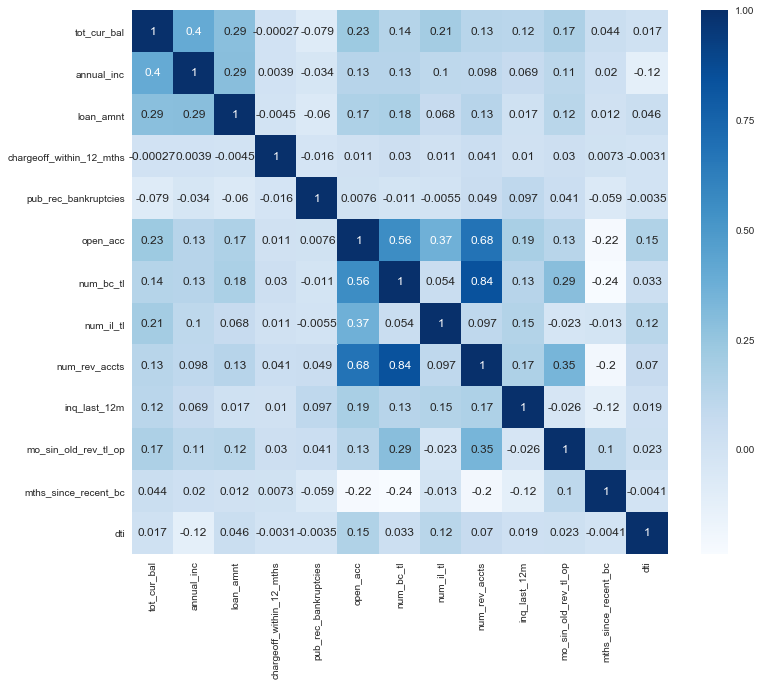

In [240]:
sb.set(rc={'figure.figsize':(12,10)})
sb.heatmap(corr,annot=True,cmap="Blues")

*Converting the Default Loans to **0** and Fully-Paid Loans to **1**.*

In [326]:
df4["loan_status"]=df4['loan_status'].map({'Default': 0, 'Fully Paid': 1})

C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [242]:
df4.to_csv("Cleaned_Loan_Data.csv")

In [255]:
df4['revol_util']=df4["revol_util"].astype(float)

C:\Users\Isha\Anaconda3\envs\dato-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Exploratory Data Analysis


In [344]:
grade=df2.groupby(['grade'])['loan_amnt'].count().reset_index()

![Grade Distribution](https://www.lendingmemo.com/wp-content/uploads/2014/09/P2P-Lending-Loan-Grades-2014.png)

**We see the number of loans in each grade**

Text(0.5,1,u'LOAN GRADES')

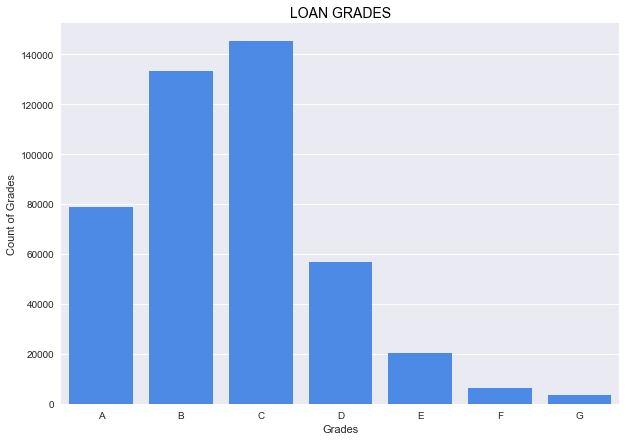

In [363]:
sb.set(rc={'figure.figsize':(10,7)})
sb.barplot(x="grade",y="loan_amnt",data=grade,color='#3385ff')
plt.ylabel("Count of Grades")
plt.xlabel("Grades")
plt.title("LOAN GRADES",color="BLACK",fontsize=14)

**And how interest rate is distributed in each grade**

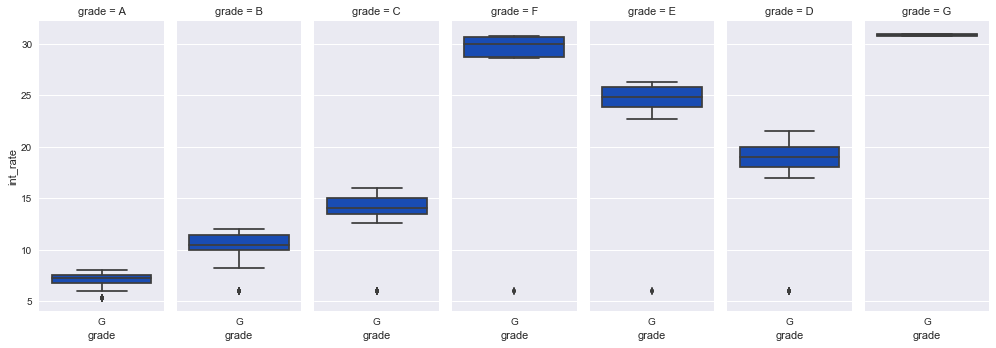

In [373]:
g = sb.FacetGrid(df2, col="grade", size=5, aspect=.4)
g.map(sb.boxplot, "grade", "int_rate",color="#0044cc");

In [380]:
y=df2[(df2['loan_status']=="Charged Off") |(df2['loan_status']=="Late (31-120 days)")|(df2['loan_status']=="In Grace Period")]

Text(0.5,1,u'Count of grades in Default Loans')

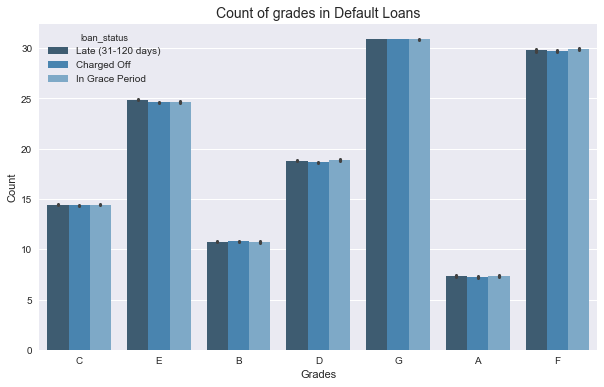

In [384]:
sb.set(rc={'figure.figsize':(10,6)})
sb.set_style("darkgrid")
sb.barplot(x="grade", y="int_rate",hue="loan_status", data=y, palette="Blues_d")
plt.xlabel("Grades")
plt.ylabel("Count")
plt.title("Count of grades in Default Loans",fontsize=14)